### Installation
- `pip install eleanor` ([eleanor Docs](http://adina.feinste.in/eleanor))
- Through Github ([eleanor GitHub](https://github.com/afeinstein20/eleanor))

In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16

## Step 1: Initiating eleanor.Source
To use `eleanor` you need some identifier for your target. This can be either the TIC ID, a set of coordinates, a Gaia ID, or the name of your star. If you know the sector your target was observed in, that's great! If not, that's okay. You don't need to set the `sector` argument. Instead, `eleanor` will pass back the latest sector your target was observed in. For example, for a CVZ target, `eleanor.Source` will return data from Sector 13.

In [2]:
star = eleanor.Source(name='WASP-100', sector=3)

//anaconda3/lib/python3.7/site-packages/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_bkg.fits with expected size 79323840. [astroquery.query]
INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc.fits with expected size 158760000. [astroquery.query]
INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2_tess_v2_pm.txt with expected size 238620. [astroquery.query]


Above, we have downloaded a few `eleanor` data products: a postcard, a 2D background model on the postcard level, and a pointing model. These products are currently only available for the first 13 sectors, but will be created for the Northern hemisphere (Sectors 14-26) as well.

----

Whatever identifier you pass in, `eleanor` will crossmatch with the corresponding TIC ID, coordinates, and/or Gaia ID.

In [3]:
star.tic, star.coords, star.gaia

(38846515, (68.95970916666666, -64.02703666666666), 4675352109658261376)

The `eleanor.Source` class also provides information on where your target was observed on the TESS CCDs: 

In [4]:
star.sector, star.camera, star.chip

(3, 4, 2)

## Step 2: Making a light curve
`eleanor.Source` set us up with everything we need to make the light curve. To do this, we need to create an `eleanor.TargetData` object. There are some additional arguments that we can use here, such as setting the Target Pixel File (TPF) height and width, creating a point-spread function (PSF) modeled light curve, and creating a principle component analysis (PCA) light curve.

We'll do both the PSF light curve, by setting `do_psf=True`, and the PCA light curve, by setting `do_pca=True`, for this example.

In [5]:
data = eleanor.TargetData(star, do_psf=True, do_pca=True)

Set MJD-OBS to 58381.542202 from DATE-OBS.
Set DATE-BEG to '2018-09-20T13:01:55.436' from MJD-BEG'. [astropy.wcs.wcs]
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)

In addition to different types of light curves, we are also trying a few different background subtraction methods to remove as much background noise as possible. The three options `eleanor` tries are:
- 1D postcard background: A constant calculated from each postcard frame, masking stars.
- 1D TPF background: A constant calculated froom each TPF frame, masking stars.
- 2D background: The 2D background pixels are subtracted from the TPF.
    
The postcard and the 2D modeled background from the postcard look like this:

We can see which background produced the best light curve. And by best, the `eleanor` light curves are optimized for transit searches, so we minimized the CDPP (combined differential photometric precision) to define the "best".

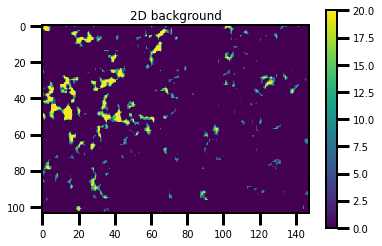

In [6]:
plt.title('2D background')
plt.imshow(data.post_obj.background2d[100], vmin=0, vmax=20)
plt.colorbar();

In [7]:
data.bkg_type

'PC_LEVEL'

"PC_LEVEL" means the 1D postcard level background removed the most systematics. This background model looks like:

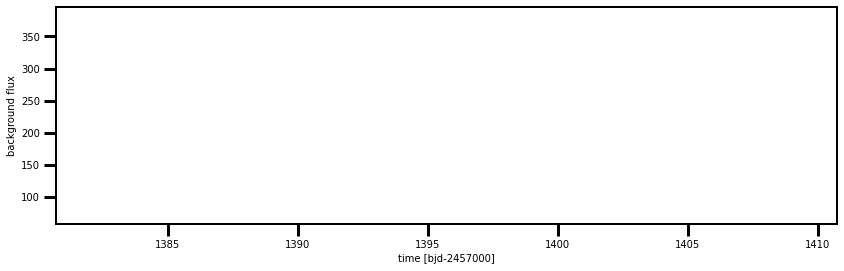

In [8]:
plt.figure(figsize=(14,4))
plt.plot(data.time, data.post_obj.bkg, 'w', lw=3)
plt.xlabel('time [bjd-2457000]')
plt.ylabel('background flux');

In the same spirit, the aperture selected by `eleanor` also minimizes the CDPP. The aperture, over the target, selected looks like:

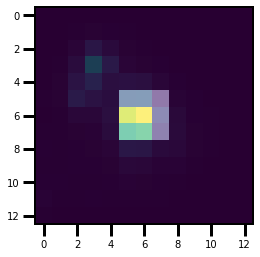

In [9]:
plt.imshow(data.tpf[100])
plt.imshow(data.aperture, alpha=0.4, cmap='Greys_r');

Or this can be better seen using the `eleanor.Visualize` class:

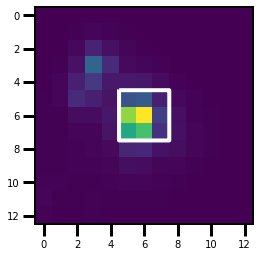

In [10]:
vis = eleanor.Visualize(data)
fig = vis.aperture_contour()

## Step 3: Look at your light curves!
It's time to see what was created:

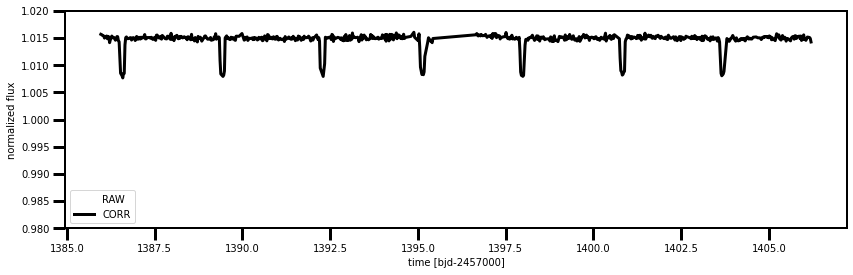

In [11]:
q = data.quality == 0

plt.figure(figsize=(14,4))
plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])-0.005, 'w', lw=3,
        label='RAW')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q])+0.015, 'k', lw=3,
        label='CORR')
plt.ylim(0.98,1.02)
plt.xlabel('time [bjd-2457000]')
plt.ylabel('normalized flux')
plt.legend();

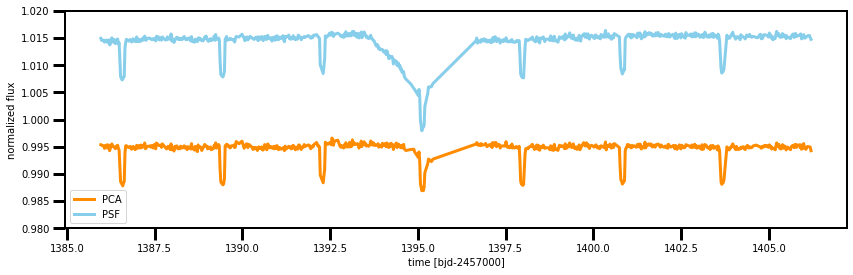

In [12]:
plt.figure(figsize=(14,4))
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q])-0.005, 'darkorange', lw=3, 
        label='PCA')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q])+0.015, 'skyblue', lw=3,
        label='PSF')
plt.ylim(0.98,1.02)
plt.xlabel('time [bjd-2457000]')
plt.ylabel('normalized flux')
plt.legend();

If you're missing all of the great tools implemented by `lightkurve`, we have an easy fix for you. By calling `eleanor.to_lightkurve()`, you will get a `lightkurve.LightCurve` object. You can also specify which flux you want passed into the object.

In [13]:
lc = data.to_lightkurve(flux=data.corr_flux)

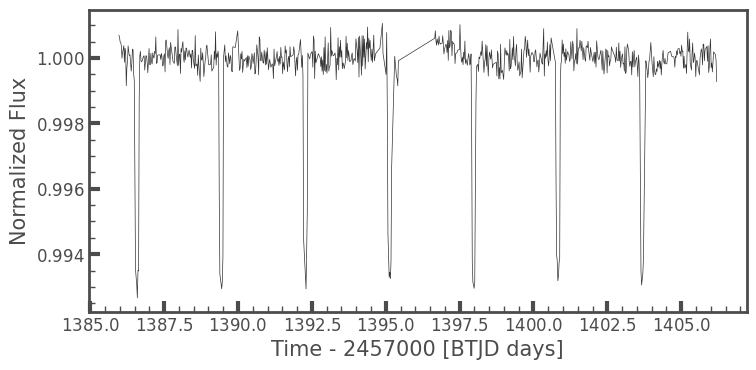

In [14]:
lc.normalize().plot()

## Step 1 (redone): What if my target was observed in multiple sectors? 

Instead of initiating an `eleanor.Source` class, you can call `eleanor.multi_sectors`, which will return a list of `eleanor.Source` objects per each sector your target was observed in. If you want specific sectors, you can pass those in as a list/array. Otherwise, if you want all of the sectors your target was observed in, you can pass in `sectors="all"` and `eleanor` will fetch all of those for you.

In [15]:
stars = eleanor.multi_sectors(tic=star.tic, sectors=np.arange(2,6,1,dtype=int))

//anaconda3/lib/python3.7/site-packages/eleanor/source.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sectors == 'all':
//anaconda3/lib/python3.7/site-packages/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")
I0908 20:15:10.616955 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_bkg.fits with expected size 76677120.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_bkg.fits with expected size 76677120. [astroquery.query]


I0908 20:15:11.082640 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc.fits with expected size 153463680.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc.fits with expected size 153463680. [astroquery.query]


I0908 20:15:11.372961 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1_tess_v2_pm.txt with expected size 231901.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-4-1-cal-1490-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-4-1_tess_v2_pm.txt with expected size 231901. [astroquery.query]


I0908 20:15:15.697803 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_bkg.fits with expected size 79323840.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_bkg.fits with expected size 79323840. [astroquery.query]


I0908 20:15:16.065125 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc.fits with expected size 158760000.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc.fits with expected size 158760000. [astroquery.query]


I0908 20:15:16.278659 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2_tess_v2_pm.txt with expected size 238620.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0003-4-2-cal-0118-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0003-4-2_tess_v2_pm.txt with expected size 238620. [astroquery.query]


I0908 20:15:19.989195 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_bkg.fits with expected size 65286720.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_bkg.fits with expected size 65286720. [astroquery.query]


I0908 20:15:20.244117 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc.fits with expected size 130665600.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc.fits with expected size 130665600. [astroquery.query]


I0908 20:15:20.525094 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2_tess_v2_pm.txt with expected size 197975.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-4-2-cal-0804-0754_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-4-2_tess_v2_pm.txt with expected size 197975. [astroquery.query]


I0908 20:15:22.807709 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_bkg.fits with expected size 73658880.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]


I0908 20:15:23.020528 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc.fits with expected size 147421440.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


I0908 20:15:23.231346 4754064832 query.py:325] Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2_tess_v2_pm.txt with expected size 222610.


INFO: Found cached file /Users/arcticfox/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-4-2-cal-1294-1294_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-4-2_tess_v2_pm.txt with expected size 222610. [astroquery.query]


In [16]:
stars

It downloads all of the postcards, 2D postcard backgrounds, and pointing models. Now, to get a light curve from each sector, you can pass it into `eleanor.TargetData` in a loop:

In [17]:
data = []

for s in stars:
    datum = eleanor.TargetData(s)
    data.append(datum)

Set MJD-OBS to 58353.604425 from DATE-OBS.
Set DATE-BEG to '2018-08-23T14:31:31.475' from MJD-BEG'. [astropy.wcs.wcs]
W0908 20:15:57.465679 4754064832 logger.py:204] FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF.
Set MJD-OBS to 58353.604425 from DATE-OBS.
Set DATE-BEG to '2018-08-23T14:31:31.475' from MJD-BEG'.
W0908 20:15:59.290387 4754064832 logger.py:204] The "exact" method is not yet implemented for rectangular apertures -- using "subpixel" method with "subpixels=32"
Set MJD-OBS to 58381.542202 from DATE-OBS.
Set DATE-BEG to '2018-09-20T13:01:55.436' from MJD-BEG'. [astropy.wcs.wcs]
W0908 20:16:02.241426 4754064832 logger.py:204] FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF.
Set MJD-OBS to 58381.542202 from DATE-OBS.
Set DATE-BEG to '2018-09-20T13:01:55.436' from MJD-BEG'.
W0908 20:16:04.159887 4754064832 logger.py:204] The "exact" method is not yet implemented for rectangular apertures -- using "subpi

And to look at our light curves:

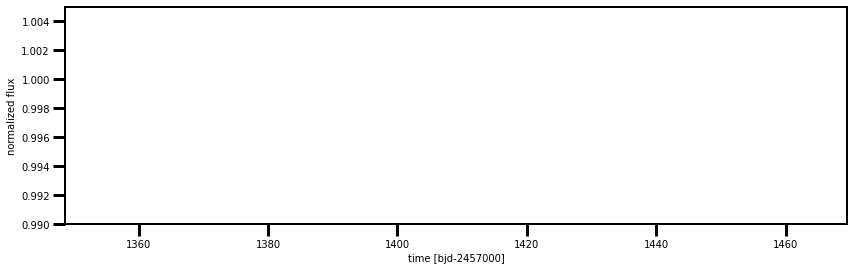

In [18]:
plt.figure(figsize=(14,4))
for d in data:
    q = d.quality == 0
    plt.plot(d.time[q], d.corr_flux[q]/np.nanmedian(d.corr_flux[q]), 'w', lw=3)
plt.ylim(0.99,1.005)
plt.xlabel('time [bjd-2457000]')
plt.ylabel('normalized flux');

## Step 4 (optional): Remember that visualization object?
Earlier we created an `eleanor.Visualize` object that allowed us to overplot a countour of the aperture on the TPF. There are other things in there to use as well when vetting your target!

One of the most useful tricks is creating a pixel-by-pixel light curve grid, to see if the signal you're seeing in the light curve is from your source or something nearby:

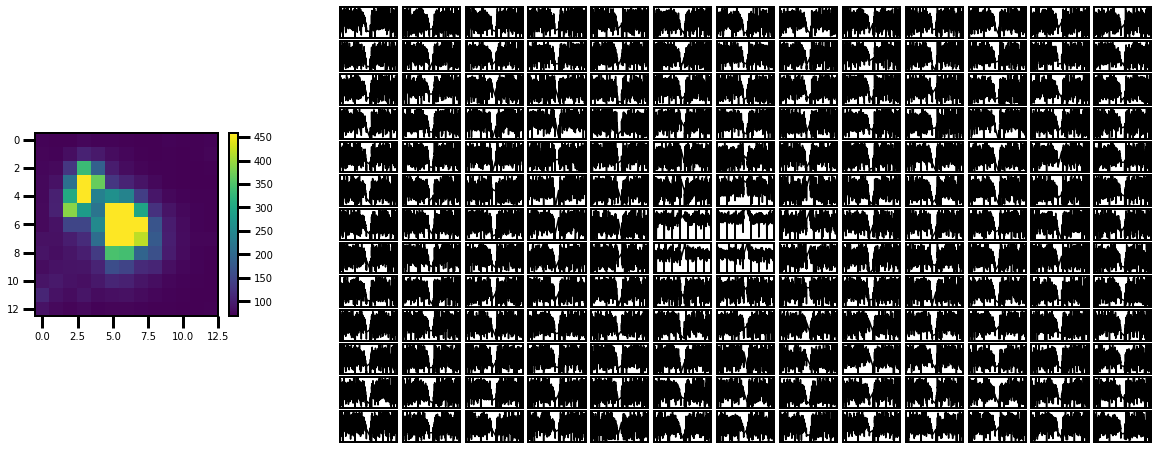

In [19]:
fig = vis.pixel_by_pixel()

Okay, maybe not useful like this, but zooming in and assigning the light curve color to be that of the TPF pixel:

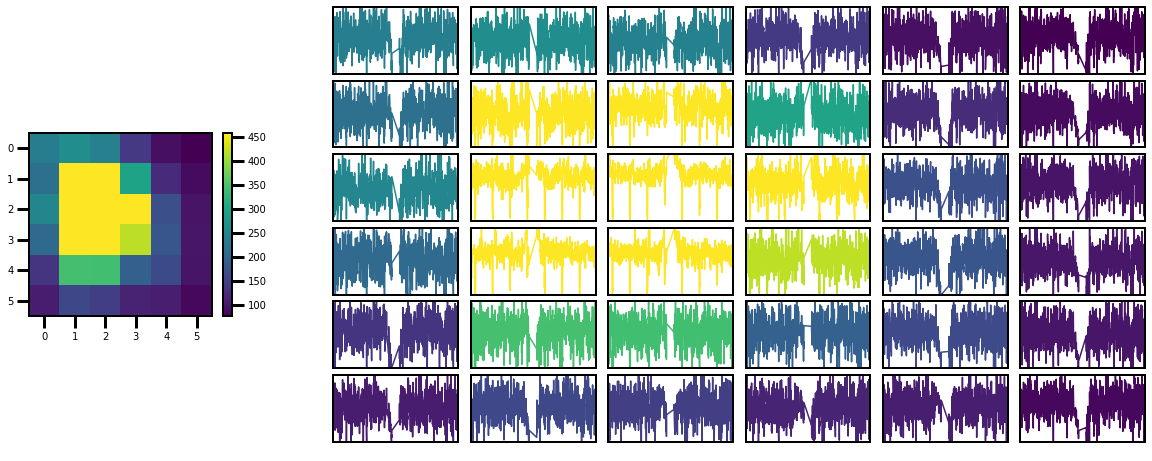

In [20]:
fig = vis.pixel_by_pixel(colrange=[4,10], rowrange=[4,10], color_by_pixel=True)

It looks like the signal is coming from the source! But just in case, you can overplot nearby Gaia sources on your TPF (thanks Nick Saunders!). The points are related to the magnitude of the source:

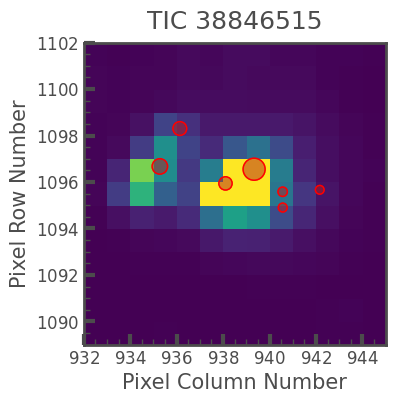

In [21]:
fig = vis.plot_gaia_overlay(magnitude_limit=16)

## Step 5 (technically optional, but should consider!): Crossmatching

Within `eleanor`, we also have tools to see if your target has a light curve produced by the TASOC team (asteroseismology), Oelkers & Stassun difference imaging pipeline, or was observed at 2-minute cadence! We can start digging by the following:

In [24]:
crossmatch = eleanor.Crossmatch(data[0])

To check for 2-minute data, we use `lightkurve` behind the scenes:

In [23]:
crossmatch.two_minute()

KeyboardInterrupt: 

Because this returns a `lightkurve.SearchResult` object, you can download the data product right from there and go about using the other `lightkurve` tools.

-----

To check out the TASOC pipeline:

In [25]:
crossmatch.tasoc_lc()

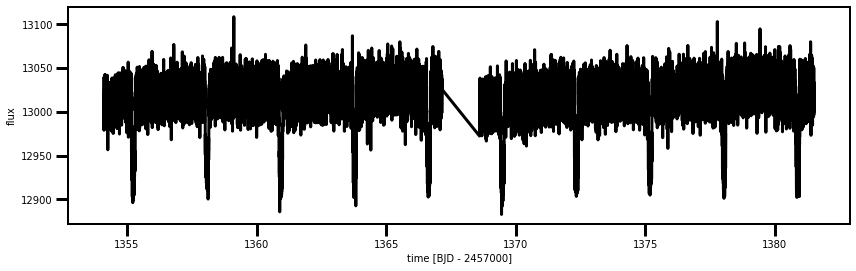

In [27]:
plt.figure(figsize=(14,4))
q = crossmatch.tasoc_pixel_quality == 0
plt.plot(crossmatch.tasoc_time[q], crossmatch.tasoc_flux_raw[q], 'k', lw=3)
plt.xlabel('time [BJD - 2457000]')
plt.ylabel('flux');

To check the Oelkers & Stassun light curves (it shouold be noted these light curves are in magnitudes!):

In [28]:
crossmatch.oelkers_lc()

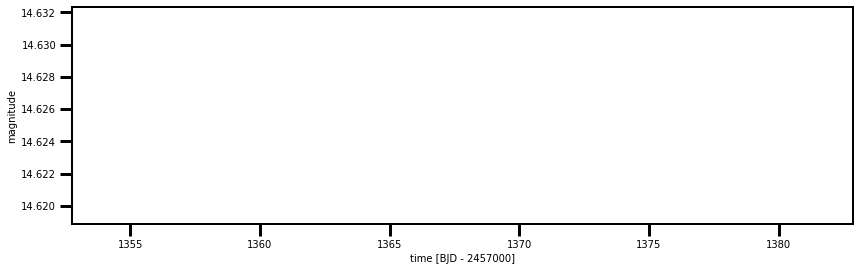

In [29]:
plt.figure(figsize=(14,4))
plt.plot(crossmatch.os_time, crossmatch.os_mag, 'w', lw=3)
plt.xlabel('time [BJD - 2457000]')
plt.ylabel('magnitude');